In [6]:
#default_exp data
#hide
from nbdev.showdoc import *
import warnings
warnings.filterwarnings('ignore')

# Exploratory Dataset Analysis

## Competition Goal
> Identify and localize COVID-19 abnormalities on chest radiographs.
> Object detection and classification problem

In [7]:
#export
from nfwk.data import *
from fastai.vision.all import *
from fastai.medical.imaging import *
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import pydicom
from tqdm.notebook import tqdm; tqdm.pandas();
import wandb
from pandarallel import pandarallel; pandarallel.initialize();
assert torch.cuda.is_available()
import plotly.express as px

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [8]:
# %matplotlib inline
!pip list | grep "torch\|cuda\|fast"

fastai                        2.4
fastcore                      1.3.20
fastprogress                  1.0.0
fastrelease                   0.1.11
torch                         1.9.0
torchvision                   0.10.0


In [9]:
PATH = setup('siim-covid19-detection')

##

## Understanding the dataset
The train dataset comprises 6334 anonymized chest scans in DICOM format. The test contains 1263 entries.

In [10]:
%%time
# XRAY Files
# Read DICOM files
train_dcm = get_dicom_files(PATH/'train/', recurse=True)
test_dcm = get_dicom_files(PATH/'test/', recurse=True)
trl, tel = len(train_dcm), len(test_dcm)
assert trl==6334
assert tel==1263
(trl+tel, trl, tel)

CPU times: user 1.98 s, sys: 1.06 s, total: 3.04 s
Wall time: 37.2 s


(7597, 6334, 1263)

Patient id.......: 045e72d7761e 
Modality.........: DX 
Rows.............: 2539 
Columns..........: 3050


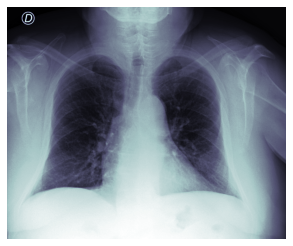

In [11]:
# Looking on a sample XRAY
xray_sample = train_dcm[123].dcmread()

# https://www.kaggle.com/cpmpml/pulmonary-fibrosis-competition-eda-dicom-prep
class bcolors:
    OKBLUE = '\033[96m'
    OKGREEN = '\033[92m'

FIG_FONT = dict(family="Helvetica, Arial", size=14, color="#7f7f7f")
LABELS = ['atypical', 'indeterminate', 'negative', 'typical']
LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 4)]

print(bcolors.OKBLUE + "Patient id.......:", xray_sample.PatientID, "\n" +
      "Modality.........:", xray_sample.Modality, "\n" +
      "Rows.............:", xray_sample.Rows, "\n" +
      "Columns..........:", xray_sample.Columns)

xray_sample.show(cmap='bone')

In [12]:
sample_df = pd.DataFrame.from_dicoms(train_dcm[:3])
sample_df.head(1).T

,0
SpecificCharacterSet,ISO_IR 100
ImageType,ORIGINAL
SOPClassUID,71228e4340de
SOPInstanceUID,8cc308497a69
StudyDate,364e93fa20e4
StudyTime,141344daa86e
AccessionNumber,e3fd6138b66d
Modality,DX
PatientName,"(7, d, 1, 8, 8, b, 2, 4, 3, e, 3, 2)"
PatientID,e7e10bc8f1a4


## Organizing the dataset

In [13]:
#export 
# From https://www.kaggle.com/dschettler8845/visual-in-depth-eda-siim-covid19-detection

def unpack_bbox_column(df_row):
    """ go from xmin,ymin,width,height --> xmin,ymin,xmax,ymax """
    df_row["xmin"] = df_row["boxes"]["x"]
    df_row["ymin"] = df_row["boxes"]["y"]
    df_row["xmax"] = df_row["boxes"]["x"]+df_row["boxes"]["width"]
    df_row["ymax"] = df_row["boxes"]["y"]+df_row["boxes"]["height"]
    return df_row

def get_human_label(row):
    """ Get human readable label for visualization purposes """
    for lbl in ["negative", "typical", "indeterminate", "atypical"]:
        if row[lbl]:
            row["human_label"] = lbl
    return row

def get_dicom_data(row):
    """ Return relevant dicom data """
    dcm = pydicom.read_file(row.dcm_path)
    row["PatientID"] = dcm.PatientID
    row["BodyPartExamined"]=dcm.BodyPartExamined
    row["height"] = dcm.Rows
    row["width"] = dcm.Columns
    row["pixel_spacing"] = float(dcm.ImagerPixelSpacing[0])
    try:
        row["series_number"] = int(dcm.SeriesNumber)
    except:
        row["series_number"] = -1
    row["monochrome"] = int(dcm.PhotometricInterpretation[-1])
    row[dcm.PatientSex] = 1
    row["SOP"] = dcm.SOPClassUID
    try:
        row["image_type"] = "-".join(sorted([x for x in dcm.ImageType if x]))
    except:
        row["image_type"] = dcm.ImageType
    row["modality"] = dcm.Modality
    
    # Triple Checks
    row["StudyInstanceUID"] = dcm.StudyInstanceUID
    row["SeriesInstanceUID"] = dcm.SeriesInstanceUID
    row["ImageInstanceUID"] = row.dcm_path[:-4].rsplit("/", 1)[1]
    
    return row

def create_fractional_bbox_coordinates(row):
    """ Function to return bbox coordinates as fractions from DF row """
    row["frac_xmin"] = row["xmin"]/row["width"]
    row["frac_xmax"] = row["xmax"]/row["width"]
    row["frac_ymin"] = row["ymin"]/row["height"]
    row["frac_ymax"] = row["ymax"]/row["height"]
    return row

In [ ]:
# Create the relevant dataframe objects
print("\n... OPEN THE IMAGE & STUDY LEVEL DATAFRAME ...\n")
train_image_level_df = pd.read_csv(PATH/'train_image_level.csv', usecols=["id", "boxes", "StudyInstanceUID"]).sort_values(by="StudyInstanceUID").reset_index(drop=True)
train_study_level_df = pd.read_csv(PATH/'train_study_level.csv')
print("\n... CONVERT BOUNDING BOX STRING REPRESENTATION TO LITERAL ...\n")
train_image_level_df["boxes"] = train_image_level_df["boxes"].fillna('{"x":0, "y":0, "width":1, "height":1}')
train_image_level_df["boxes"] = train_image_level_df["boxes"].progress_apply(lambda x: ast.literal_eval(x))
print("\n... RENAME AND FIX SOME COLUMNS IN BOTH DATAFRAMES ...\n")
train_study_level_df.columns = ["StudyInstanceUID", "negative", "typical", "indeterminate", "atypical"]
train_study_level_df["StudyInstanceUID"] = train_study_level_df["StudyInstanceUID"].str.replace("_study", "")
train_image_level_df["id"] = train_image_level_df["id"].str.replace("_image", "")
print("\n... OPEN THE SUBMISSION DATAFRAME AND CREATE TRAIN DATAFRAME ...\n")
ss_df = pd.read_csv(PATH/"sample_submission.csv")
train_df = pd.merge(train_image_level_df, train_study_level_df, on="StudyInstanceUID")

print("\n... GET THE IMAGE PATHS FOR BOTH DATA FRAMES ...\n")
ss_df["dcm_path"] = ss_df["id"].str.replace("_study", "")\
                               .str.replace("_image", "")\
                               .progress_apply(lambda x: [str(z) for z in test_dcm if x in str(z)][-1])
train_df["dcm_path"] = train_df["id"].progress_apply(lambda x: [str(z) for z in train_dcm if x in str(z)][-1])

In [ ]:
%%time
print("\n... CAPTURE RELEVANT DICOM DATA FOR TRAIN DATAFRAME (~22 MINUTES)...")
train_df = train_df.parallel_apply(lambda row: get_dicom_data(row), axis=1)

In [ ]:
%%time
print("... CAPTURE RELEVANT DICOM DATA FOR SUBMISSION DATAFRAME (~4 MINUTES)...\n")
ss_df = ss_df.parallel_apply(lambda row: get_dicom_data(row), axis=1)

In [ ]:
with open(PATH/'train_df.pickle', 'wb') as handle:
    pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(PATH/'test_df.pickle', 'wb') as handle:
    pickle.dump(ss_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(PATH/'train_df.pickle', 'rb') as handle:
    train_df = pickle.load(handle)
with open(PATH/'test_df.pickle', 'rb') as handle:
    ss_df = pickle.load(handle)

In [ ]:
train_df.BodyPartExamined = train_df.BodyPartExamined!='ABDOMEN'
booleanDictionary = {True: 'TORAX', False: 'ABDOMEN'}
train_df.BodyPartExamined = train_df.BodyPartExamined.map(booleanDictionary)

print("\n... EXPLODE LIST OF BOUNDING BOXES INTO INDIVIDUAL ROWS FOR TRAIN DATAFRAME ...\n")
train_df["boxes"] = train_df.boxes.progress_apply(lambda x: [x] if type(x)==dict else x)
train_df = train_df.explode("boxes", ignore_index=True).reset_index(drop=True)

print("\n... CONVERT BBOX COORDINATES INTO RESPECTIVE COLUMNS ...\n")
train_df = train_df.progress_apply(unpack_bbox_column, axis=1)
train_df = train_df.sort_values(by="id").reset_index(drop=True)

print("\n... CREATE HUMAN LABEL COLUMN ...\n")
train_df = train_df.progress_apply(get_human_label, axis=1)

print("\n... INITIALIZE THE GENDER COLUMNS ...\n")
train_df["M"] = train_df["F"] = ss_df["M"] = ss_df["F"] = 0

print("\n... REORDER TRAIN DATAFRAME ...\n")
train_col_order = [
    "id", "PatientID", "StudyInstanceUID", "SeriesInstanceUID", "ImageInstanceUID", "dcm_path", 
    "xmin", "ymin", "xmax", "ymax", "width", "height",
    "human_label", "negative", "typical", "indeterminate", "atypical", 
    "series_number", "modality", "monochrome", "M", "F", "image_type", "pixel_spacing", "SOP", "BodyPartExamined"]
train_df = train_df[train_col_order]

print("\n... REORDER SUBMISSION DATAFRAME ...\n")
ss_df = ss_df[[col for col in train_col_order if col in ss_df.columns]+["PredictionString",]]

print("\n... CREATE FRACTIONAL BBOX COORDINATES ...\n")
train_df = train_df.progress_apply(create_fractional_bbox_coordinates, axis=1)

print("\n... CREATE INTEGER LABEL COLUMN ...\n")

train_df["integer_label"] = train_df["human_label"].progress_apply(lambda x: LABELS.index(x))

In [ ]:
print("\n\nCOMBINED AND EXPLODED TRAIN DATAFRAME\n\n")
display(train_df)

print("\n\nSAMPLE SUBMISSION DATAFRAME\n\n")
display(ss_df)

## Background Information

- NEGATIVE FOR PNEUMONIA: No lung opacities
- TYPICAL APPEARANCE: Multifocal bilateral, peripheral opacities with rounded morphology, lower lung–predominant distribution
- INDETERMINATE APPEARANCE: Absence of typical findings AND unilateral, central or upper lung predominant distribution
- ATYPICAL APPEARANCE: Pneumothorax, pleural effusion, pulmonary edema, lobar consolidation, solitary lung nodule or mass, diffuse tiny nodules, cavity

In [ ]:

with open(PATH/'train_df_trimmed.pickle', 'wb') as handle:
    pickle.dump(train_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(PATH/'test_df_trimmed.pickle', 'wb') as handle:
    pickle.dump(ss_df, handle, protocol=pickle.HIGHEST_PROTOCOL)

[host] = !hostname
host
with wandb.init(project='siim-covid19', entity='nido', job_type="pre-process") as run:
  dfs = wandb.Artifact('siim-covid19-processed', type="data-frame",
      description=f'Pre-processed data-frames from dataset extracting dicom data.',
      metadata={"host": host, "path": PATH})
  dfs.add_file(PATH/'train_df_trimmed.pickle')
  dfs.add_file(PATH/'test_df_trimmed.pickle')
  # ✍️ Save the artifact to W&B.
  run.log_artifact(dfs)

In [14]:
with open(PATH/'train_df_trimmed.pickle', 'rb') as handle:
    train_df = pickle.load(handle)
with open(PATH/'test_df_trimmed.pickle', 'rb') as handle:
    ss_df = pickle.load(handle)

In [41]:
a = train_df.groupby('id').agg(['nunique'])['PatientID']
b = train_df.groupby('id').agg(['nunique'])['StudyInstanceUID']
np.unique(a==b, return_counts=True)


(array([ True]), array([6334]))

In [42]:
c = train_df.groupby('id').agg(['nunique'])['SeriesInstanceUID']
np.unique(a==c, return_counts=True)

(array([ True]), array([6334]))

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:

fig = px.bar(train_df.human_label.value_counts().sort_index(), 
             color=train_df.human_label.value_counts().sort_index().index, opacity=0.7,
             color_discrete_sequence=LABEL_COLORS,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)
fig.update_layout(legend_title=None,
                  font=FIG_FONT,
                  xaxis_title="",
                  yaxis_title="<b>Annotations Per Class</b>")

fig.show()

In [ ]:
files = get_image_files(path)

In [ ]:
files[0]

In [ ]:
len(files)

In [ ]:
def label_func(f):
    return str(f)

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func=label_func)

In [ ]:
label_func(files[0])

In [ ]:
show_doc(ImageDataLoaders.from_path_func)

In [ ]:
dls = ImageDataLoaders.from_path_func(path, files, label_func).cuda()


In [ ]:
dls.show_batch()

In [ ]:
fnmsTrain = !ls $path/"train"
lbls = pd.DataFrame([label_func(n) for n in fnmsTrain])
pd.DataFrame.value_counts(lbls)

In [ ]:
lbls.describe()